In [966]:
import random
import json
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix



In [967]:
from pathlib import Path
import os, sys
WORK_DIR = Path.cwd().parent

sys.path.append(str(WORK_DIR))
print(WORK_DIR)


/home/lusha


In [968]:
from star_code.src.datasets import CVRRDataset, JudgeDataset
from star_code.src.prompt_formatters import OpenEndedPrompt, LlmAsJudgePrompt


# Eval on CVRR


**Parameters:**
- model: gemma3:4b-it-qat

## QA on generated graphs

System prompt

In [969]:
with open(WORK_DIR / 'cvrr/sys_prompt.txt', 'r') as f:
    sys_prompt = f.read()

print(sys_prompt)


# Video Question-Answering System Prompt

You are an AI assistant specialized in answering questions about videos based on their scene graph representations. Instead of receiving raw video data, you will be provided with structured scene graph information that captures the key visual and temporal elements of the video content.

## Input Format

You will receive two inputs:
1. **Question**: An open-ended question about the video content
2. **Scene Graph Representation**: A structured representation of the video containing:

### Scene Graph Structure
- **Objects**: Entities present in the video (people, animals, objects, etc.)
- **Attributes**: Properties of objects (color, size, position, state, etc.)
- **Relationships**: Spatial and semantic connections between objects
- **Temporal Information**: How objects and relationships change over time
- **Actions/Events**: Activities and interactions occurring in the video
- **Scene Context**: Location, setting, environmental details

### Examp

User prompt

In [970]:
with open(WORK_DIR / 'cvrr/user_prompt.txt', 'r') as f:
    user_prompt = f.read()

print(user_prompt)


# Video Question-Answering User Prompt Template

## Question
{question}

## Spatio-Temporal Scene Graph Representation
{stsg}

---

Please analyze the provided scene graph representation and answer the question based on the visual and temporal information contained within it.


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [971]:
user_prompt_formatter = OpenEndedPrompt(user_prompt)
qa_cvrr_dataset = CVRRDataset(
    qa_file_path=WORK_DIR/"cvrr/cvrr_val_updated.json",
    prompt_formatter=user_prompt_formatter,
    stsg_file_path=WORK_DIR/"cvrr/generated_stsg_cvrr.json"
)



Dataset Statistics:
QA File: cvrr_val_updated.json
Number of QA samples: 2400
QA sample keys: dimension_name, subset, question_id, question, video_id, answer

STSG File: generated_stsg_cvrr.json
Number of unique video IDs with STSG: 193



In [972]:
# example of entry
qa_cvrr_dataset[0]


{'dimension_name': 'Continuity and Object Instance Count',
 'subset': 'continuity_and_object_instance_count',
 'question_id': '2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0',
 'question': 'How many times is the golden hollow sphere gets covered by other objects?',
 'video_id': 'continuity_and_object_instance_count_183',
 'answer': 'The golden hollow sphere is covered two times by other objects.',
 'stsg': '\nFrame 0:\n\n\npurple_cube ---- above ---- yellow_sphere\npurple_cube ---- adjacent_to ---- green_cone\npurple_cube ---- adjacent_to ---- red_cone\ngreen_cone ---- to_the_left_of ---- purple_cube\nred_cone ---- to_the_right_of ---- purple_cube\nyellow_sphere ---- below ---- purple_cube\ngreen_cone ---- positioned_near ---- purple_cube\nred_cone ---- positioned_near ---- purple_cube\nyellow_sphere ---- directly_under ---- purple_cube\npurple_cube ---- supporting ---- yellow_sphere\n\nFrame 1:\n\n\nred_sphere ---- above ---- green_cone\ngreen_cone ---- above ---- purple_cube\npurple_cube ---- 

In [973]:
print(qa_cvrr_dataset[0]["prompt"])


# Video Question-Answering User Prompt Template

## Question
How many times is the golden hollow sphere gets covered by other objects?

## Spatio-Temporal Scene Graph Representation

Frame 0:


purple_cube ---- above ---- yellow_sphere
purple_cube ---- adjacent_to ---- green_cone
purple_cube ---- adjacent_to ---- red_cone
green_cone ---- to_the_left_of ---- purple_cube
red_cone ---- to_the_right_of ---- purple_cube
yellow_sphere ---- below ---- purple_cube
green_cone ---- positioned_near ---- purple_cube
red_cone ---- positioned_near ---- purple_cube
yellow_sphere ---- directly_under ---- purple_cube
purple_cube ---- supporting ---- yellow_sphere

Frame 1:


red_sphere ---- above ---- green_cone
green_cone ---- above ---- purple_cube
purple_cube ---- on ---- surface
red_sphere ---- above ---- green_cone
green_cone ---- looking_at ---- purple_cube
red_sphere ---- looking_at ---- green_cone
purple_cube ---- on_top_of ---- surface
green_cone ---- attached_to ---- red_sphere
surface ---- s

In [974]:
predictions = []
with open(WORK_DIR / "cvrr/cvrr_qa_responses_maxsample50.jsonl") as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id'})
predictions_df.set_index('id', inplace=True)

ans_df = predictions_df
ans_df = ans_df.rename(columns={'response': 'text'})
ans_df


,text
id,
2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0,The golden hollow sphere (red_sphere) is cover...
b27163c5-d341-475b-8517-54809872081a,Does the pink cube and shiny pink cube undergo...
9bce3140-e8e8-49dd-8574-5e961326fb16,Based on the provided scene graph representati...
b8df9fbe-07db-46ab-ba17-3713c1632dbd,Based on the provided scene graph representati...
01c30c62-f489-4246-af18-b7b538b4cb9d,**Question**: How many total objects are prese...
...,...
4073994c-e4ca-4592-b001-fe0a79ab0e3f,"Based on the provided scene graph, the video a..."
3a158fb7-38cb-49b4-91e8-0cb63d6bf218,"Okay, I've analyzed the provided scene graph r..."
247a493d-0d24-4f1b-bbf6-b03e8973b544,Based on the provided scene graph representati...


## LLM as judge evaluation

System prompt

In [975]:
with open(WORK_DIR / 'star_code/data/prompts/llm-as-judge/LLM_judge_system_v3.txt', 'r') as f:
    sys_prompt = f.read()

print(sys_prompt)


You are an intelligent chatbot designed for evaluating the correctness of AI assistant predictions for
question-answer pairs.
Your task is to compare the predicted answer with the ground-truth answer and determine if the predicted
answer is correct or not. Here is how you can accomplish the task:
------
##INSTRUCTIONS:
- The question is enclosed by the tags <question>...</question>
- The ground truth answer is enclosed by the tags <ground_truth_answer>...</ground_truth_answer>
- The answer given by the assistant is enclosed by the tags <given_answer>...</given_answer>

- Focus on the correctness and accuracy of the predicted answer with the ground truth.
- Consider predictions with fewer specific details as correct evaluation, unless such details are explicitly
asked in the question.
- Do not penalize predictions that make reasonable assumptions outside the provided context, as long as 
they do not contradict the ground truth.
- Answers should be judged on semantic equivalence rather t

User prompt

In [976]:
with open(WORK_DIR / 'star_code/data/prompts/llm-as-judge/LLM_judge_user_v3.txt', 'r') as f:
    user_prompt = f.read()

print(user_prompt)


Please evaluate the following question-answer pair:

<question>
{question}
</question>

<given_answer>
{prediction}
</given_answer>

<ground_truth_answer>
{gt_answer}
</ground_truth_answer>

- Provide your evaluation as a correct/incorrect prediction along with a score, where the score is an integer value between 0 (fully wrong) and 5 (fully correct). The score reflects the degree of correctness:
  - 5: Fully correct, semantically equivalent to the ground truth.
  - 4: Mostly correct, with minor inaccuracies or omissions.
  - 3: Partially correct, with some significant inaccuracies.
  - 2: Mostly incorrect, but with some relevant information.
  - 1: Slightly relevant, but largely incorrect.
  - 0: Fully incorrect or irrelevant.

- Generate the response in the form of a Python dictionary string with keys 'reason', 'pred', and 'score'. The value of 'pred' should be a string of 'correct' or 'incorrect', the value of 'score' should be an INTEGER (not a string), and the value of 'reason' sh

In [977]:
judge_prompt_formatter = LlmAsJudgePrompt(user_prompt)
judge_cvrr_dataset = JudgeDataset(
    dataset=qa_cvrr_dataset,
    predictions_filepath=WORK_DIR/"cvrr/cvrr_qa_responses_maxsample50.jsonl",
    prompt_formatter=judge_prompt_formatter
)


In [978]:
judge_cvrr_dataset[0]


{'dimension_name': 'Continuity and Object Instance Count',
 'subset': 'continuity_and_object_instance_count',
 'question_id': '2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0',
 'question': 'How many times is the golden hollow sphere gets covered by other objects?',
 'video_id': 'continuity_and_object_instance_count_183',
 'answer': 'The golden hollow sphere is covered two times by other objects.',
 'stsg': '\nFrame 0:\n\n\npurple_cube ---- above ---- yellow_sphere\npurple_cube ---- adjacent_to ---- green_cone\npurple_cube ---- adjacent_to ---- red_cone\ngreen_cone ---- to_the_left_of ---- purple_cube\nred_cone ---- to_the_right_of ---- purple_cube\nyellow_sphere ---- below ---- purple_cube\ngreen_cone ---- positioned_near ---- purple_cube\nred_cone ---- positioned_near ---- purple_cube\nyellow_sphere ---- directly_under ---- purple_cube\npurple_cube ---- supporting ---- yellow_sphere\n\nFrame 1:\n\n\nred_sphere ---- above ---- green_cone\ngreen_cone ---- above ---- purple_cube\npurple_cube ---- 

In [979]:
print(judge_cvrr_dataset[0]['prompt'])


Please evaluate the following question-answer pair:

<question>
How many times is the golden hollow sphere gets covered by other objects?
</question>

<given_answer>
The golden hollow sphere (red_sphere) is covered by other objects in the following frames:

*   **Frame 0:** Covered by purple_cube.
*   **Frame 1:** Covered by red_cone.
*   **Frame 2:** Covered by red_cone.
*   **Frame 3:** Covered by green_sphere.
*   **Frame 4:** Covered by purple_cube.
*   **Frame 5:** Covered by purple_cube.
*   **Frame 6:** Covered by purple_cube.
*   **Frame 7:** Covered by purple_cube.
*   **Frame 8:** Covered by purple_cube.
*   **Frame 9:** Covered by purple_cube.
*   **Frame 10:** Covered by purple_cube.
*   **Frame 11:** Covered by purple_cube.

Therefore, the red_sphere is covered by purple_cube a total of 12 times across the provided frames.
</given_answer>

<ground_truth_answer>
The golden hollow sphere is covered two times by other objects.
</ground_truth_answer>

- Provide your evaluation

## Loading the the Judge evaluation

Now we load the judge evaluation on the responses of the perdictor model. The set of responses are saved in two different files. `llama8b_as_judge_wrong.jsonl` contains the responses that were classified as incorrect by the method with the method extraction, `llama8b_as_judge_correct.jsonl` contains the responses classified as correct.  
These two files contains only the responses for which it was able to extract an answer with the regex.

In [980]:
# Load the scores for the wrong answers
predictions = []
with open(WORK_DIR / "cvrr/our_judge_eval_maxsample50.jsonl", 'r', encoding='utf-8') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# Extract pred, score and reason from response dictionary into separate columns
judge_pred_df = pd.DataFrame(predictions).rename(columns={'qid':'id'})
judge_pred_df.set_index('id', inplace=True)
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  2400 non-null   object
dtypes: object(1)
memory usage: 37.5+ KB


## Handle formatting issues

For Gemma we need to be more careful becuase the format is different, it encapsulated the json output in the with the tokens: 
```
```json\n
<actual_answer>
\n```
```

In [981]:

# Create mask for answers that follow JSON syntax
json_mask = judge_pred_df['response'].str.match(r'^(```json\s)?({[^}]+})(\s```)?$')
matches_json_template = json_mask.sum()

print(f"Total answers: {len(judge_pred_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(judge_pred_df))*100:.2f}%")


Total answers: 2400
Answers following JSON template: 2199
Percentage following JSON template: 91.62%


In [982]:
judge_pred_df.loc[json_mask, 'response'] = \
    judge_pred_df.loc[json_mask, 'response'] \
    .apply(lambda x: re.search(r'^(?:```json\s)?({[^}]+})(?:\s```)?$', x).group(1))

judge_pred_df.loc[~json_mask, 'response'] = ""
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  2400 non-null   object
dtypes: object(1)
memory usage: 102.0+ KB


In [983]:
# Replace new line (lead to EOF Errors) with whitespace
judge_pred_df['response'] = \
    judge_pred_df['response'].str.replace('\n+', ' ', regex=True)

# Replace lef and right quotation mark with simple quotation mark
judge_pred_df['response'] = \
    judge_pred_df['response'].str.replace('[\u2018-\u201b]', '\'', regex=True)
judge_pred_df['response'] = \
    judge_pred_df['response'].str.replace('[\u201c\u201d]', '"', regex=True)


In [984]:
# sometimes the model writes outside the {...} bounderies
# let's keep only the relevant part
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            r"(\{.*?\})", 
            r"\1", 
            row['response']),
        axis=1
        )


In [985]:
test = judge_pred_df.iloc[1320]["response"]
print(test)


{'reason': "The given answer \"Okay, I'm ready to analyze the scene graph and answer the question. Please provide the question.\" does not actually answer the question. It simply states the assistant's readiness to analyze the scene graph. The question asks whether a specific scene exists, and the given answer fails to address this directly. Therefore, the prediction is incorrect. \"pred\": \"incorrect\", \"score\": 1}


In [986]:
# # unbalanced quotes test
pattern = rf"[\'\"](reason)[\'\"]:\s*([\"\'])(.*?)((?<!(?<!\\)\2))\s*(,)?\s*[\"\']pred..(?!$)"
#pattern = rf"[\'\"](reason)[\'\"]:\s*([\"\'])(.*?)((?<!(?<!\\)\2)(,)?\s*)(?=[\'\"]pred..)(?!$)"
re.findall(
    pattern,
    test
)


[('reason',
  '"',
  'The given answer \\"Okay, I\'m ready to analyze the scene graph and answer the question. Please provide the question.\\" does not actually answer the question. It simply states the assistant\'s readiness to analyze the scene graph. The question asks whether a specific scene exists, and the given answer fails to address this directly. Therefore, the prediction is incorrect. \\',
  '',
  '')]

In [987]:
subbed = re.sub(
            pattern,
            lambda m: "\'" + m.group(1) + "\': \"" + m.group(3) + "\", \'pred\'",
            test)
print(subbed)


{'reason': "The given answer \"Okay, I'm ready to analyze the scene graph and answer the question. Please provide the question.\" does not actually answer the question. It simply states the assistant's readiness to analyze the scene graph. The question asks whether a specific scene exists, and the given answer fails to address this directly. Therefore, the prediction is incorrect. \", 'pred': \"incorrect\", \"score\": 1}


In [988]:
def adjust_unbalanced_quotes(text):
    fields = ['reason', 'pred', 'score']
    for i in range(len(fields)-1):
        field = fields[i]
        delimiter = rf"{fields[i+1]}"

        # (?<!<txt>): negative look-behind assert. current position in the string is not preceed by <txt> 
        pattern = rf"[\'\"]({field})[\'\"]:\s*([\"\'])(.*?)((?<!(?<!\\)\2))\s*(,)?\s*[\'\"]{fields[i+1]}..(?!$)"
        subbed = re.sub(
            pattern,
            lambda m: "\'" + m.group(1) + "\': \"" + m.group(3) + f"\", \'{fields[i+1]}\'",
            text)
        return subbed
    

test_o = adjust_unbalanced_quotes(test)
print(repr(test_o))
#eval(test_o)


'{\'reason\': "The given answer \\"Okay, I\'m ready to analyze the scene graph and answer the question. Please provide the question.\\" does not actually answer the question. It simply states the assistant\'s readiness to analyze the scene graph. The question asks whether a specific scene exists, and the given answer fails to address this directly. Therefore, the prediction is incorrect. \\", \'pred\': \\"incorrect\\", \\"score\\": 1}'


In [989]:
# single quotes test
pattern = r"[\"\']reason[\'\"]:\s+\'(.*)\'\s*(?=,\s*[\"\']pred)"
re.findall(
    pattern,
    test_o
)


[]

In [990]:
# # unescaped doublequotes test
inside_doublequotes = r"([\"\']reason[\"\']:\s*\")(.*\".*)\"\s*(?=,\s*[\"\']pred)"

re.findall(
    inside_doublequotes,
    test_o
)



[('\'reason\': "',
  'The given answer \\"Okay, I\'m ready to analyze the scene graph and answer the question. Please provide the question.\\" does not actually answer the question. It simply states the assistant\'s readiness to analyze the scene graph. The question asks whether a specific scene exists, and the given answer fails to address this directly. Therefore, the prediction is incorrect. \\')]

In [991]:
test_o = re.sub(
    inside_doublequotes, 
    lambda matchobj: matchobj.group(1) + matchobj.group(2).replace('\"', '\'') + "\"", 
    test)

print(repr(test_o))
# eval(test_o)


'{\'reason\': "The given answer \\"Okay, I\'m ready to analyze the scene graph and answer the question. Please provide the question.\\" does not actually answer the question. It simply states the assistant\'s readiness to analyze the scene graph. The question asks whether a specific scene exists, and the given answer fails to address this directly. Therefore, the prediction is incorrect. \\"pred\\": \\"incorrect\\", \\"score\\": 1}'


In [992]:
# Adgust fields that are only-half quoted (no end quote) or mismatching quotes


def adjust_unbalanced_quotes(text):
    fields = ['reason', 'pred', 'score']
    for i in range(len(fields)-1):
        field = fields[i]
        delimiter = rf"(?:,\s*[\"\']{fields[i+1]})"

        # (?<!<txt>): negative look-behind assert. current position in the string is not preceed by <txt> 
        pattern = rf"[\'\"]({field})[\'\"]:\s*([\"\'])(.*?)(?=(?<!(?<!\\)\2){delimiter})(?!$)"
        subbed = re.sub(
            pattern,
            lambda m: "\'" + m.group(1) + "\': \"" + m.group(3) + "\"",
            text)
        return subbed
    
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: adjust_unbalanced_quotes(row['response']),
        axis=1
        )


In [993]:
eval(judge_pred_df.iloc[1211]["response"])


{'reason': 'The given answer states, "No, the interaction with the mobile phone occurs after drinking." However, the provided scene graph description indicates that the woman is initially holding the phone *before* she gets a drink. The prediction contradicts the information presented in the scene graph. Therefore, the prediction is incorrect.',
 'pred': 'incorrect',
 'score': 1}

In [994]:
# some times the model is enclosed by \' \'
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            r"[\"\']reason[\'\"]:\s+\'(.*)\'\s*(?=,\s*[\"\']pred)", 
            lambda matchobj: "\'reason\': \"" + matchobj.group(1)+ "\"", 
            row['response']),
        axis=1
        )


In [995]:
eval(judge_pred_df.iloc[1211]['response'])


{'reason': 'The given answer states, "No, the interaction with the mobile phone occurs after drinking." However, the provided scene graph description indicates that the woman is initially holding the phone *before* she gets a drink. The prediction contradicts the information presented in the scene graph. Therefore, the prediction is incorrect.',
 'pred': 'incorrect',
 'score': 1}

In [996]:
# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason parameter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"([\"\']reason[\"\']:\s*\")(.*\".*)\"\s*(?=,\s*[\"\']pred)"

judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(1) + matchobj.group(2).replace('\"', '\'') + "\"", 
            row['response']),
        axis=1
        )

judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  2400 non-null   object
dtypes: object(1)
memory usage: 102.0+ KB


In [997]:
eval(judge_pred_df.iloc[1211]['response'])


{'reason': "The given answer states, 'No, the interaction with the mobile phone occurs after drinking.' However, the provided scene graph description indicates that the woman is initially holding the phone *before* she gets a drink. The prediction contradicts the information presented in the scene graph. Therefore, the prediction is incorrect.",
 'pred': 'incorrect',
 'score': 1}

In [998]:
judge_pred_df = judge_pred_df.loc[json_mask]
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2199 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  2199 non-null   object
dtypes: object(1)
memory usage: 34.4+ KB


In [999]:
for i in range(judge_pred_df.shape[0]):
    try:
        pr = judge_pred_df.iloc[i]["response"]
        if(pr == ''):
            continue
        eval(pr)
    except:
        print(i)
        print(pr)


1211
{'reason': "The given answer \"Okay, I'm ready to analyze the scene graph and answer the question. Please provide the question.\" does not actually answer the question. It simply states the assistant's readiness to analyze the scene graph. The question asks whether a specific scene exists, and the given answer fails to address this directly. Therefore, the prediction is incorrect. \"pred\": \"incorrect\", \"score\": 1}
1919
{   "reason": "The given answer \"Okay, I'm ready to analyze the scene graph and answer the question. Please provide the question you want me to answer.\" does not provide any specific actions the woman takes to express her frustration. It simply states the assistant's readiness to analyze the scene graph. This is a completely irrelevant response to the question. Therefore, the prediction is incorrect. \"pred\": \"incorrect\", \"score\": 0}
1972
{'reason': "The given answer states: \"Based on the provided scene graph, the prank depicted in the video appears to 

In [1000]:
# remove difficult to adjust lines:
hard = [1211, 1919, 1972, 2156]
judge_pred_df = judge_pred_df.drop(judge_pred_df.iloc[hard].index)



## Extract answers

In [1001]:
# Extract pred, score and reason from response dictionary into separate columns
judge_pred_df['pred'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['pred']) \
    .astype('string') 

judge_pred_df['score'] = \
    judge_pred_df['response'] \
    .apply(lambda x: int(eval(x)['score'])) \
    .astype('int32')

judge_pred_df['reason'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['reason']) \
    .astype('string')

judge_pred_df.drop('response', axis=1, inplace=True)
judge_pred_df


,pred,score,reason
id,,,
2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0,incorrect,1,"The given answer states: 'Therefore, the red_s..."
b27163c5-d341-475b-8517-54809872081a,correct,5,The given answer 'Based on the provided scene ...
9bce3140-e8e8-49dd-8574-5e961326fb16,incorrect,3,The given answer states 'There are a total of ...
b8df9fbe-07db-46ab-ba17-3713c1632dbd,incorrect,1,The given answer states: 'The golden hollow sp...
01c30c62-f489-4246-af18-b7b538b4cb9d,incorrect,2,The given answer states 'There are a total of ...
...,...,...,...
4073994c-e4ca-4592-b001-fe0a79ab0e3f,incorrect,1,"The given answer states, 'The video does not s..."
3a158fb7-38cb-49b4-91e8-0cb63d6bf218,incorrect,2,The given answer provides a detailed descripti...
247a493d-0d24-4f1b-bbf6-b03e8973b544,incorrect,1,The given answer states: 'The woman is using a...


In [1002]:
judge_pred_df.shape


(2195, 3)

### Filtering-out answers associated to few *extracted* frames

In [1003]:
GEN_STSG_50 = WORK_DIR / "cvrr/generated_stsg_cvrr_maxsample50.jsonl"


In [1004]:
stsg_data = []
with open(GEN_STSG_50, 'r') as f:
    stsg_data = [json.loads(line) for line in f]


In [1005]:
def get_highest_frame_number(text):
    # Regular expression to match "Frame dd:" pattern where dd is one or more digits
    frame_pattern = r'Frame\s+(\d+):'
    
    # Find all frame numbers
    matches = re.findall(frame_pattern, text)
    
    if not matches:
        return None
    
    # Convert to integers and return the maximum
    frame_numbers = [int(match) for match in matches]
    return max(frame_numbers)


In [1006]:
lengths = {}
for item in stsg_data:
    lengths[item['video_id']] = get_highest_frame_number(item['stsg'])
    
sum([v for _, v in lengths.items()])/len(lengths)


20.06217616580311

In [1007]:
lengths_se = pd.Series(lengths)
lengths_se


partial_actions_126                                           2
multiple_actions_in_a_single_video_69                        32
multiple_actions_in_a_single_video_78                        46
multiple_actions_in_a_single_video_79                        31
multiple_actions_in_a_single_video_61                        30
                                                             ..
interpretation_of_social_context_37                           4
non_existent_actions_with_existent_scene_depictions_51        1
non_existent_actions_with_non_existent_scene_depictions_0     0
non_existent_actions_with_non_existent_scene_depictions_6     0
partial_actions_122                                           1
Length: 193, dtype: int64

In [1008]:
min_frames = 5

print(f"Number of videos with at least {min_frames} frames: {(lengths_se > 5).sum()}")


Number of videos with at least 5 frames: 162


### Link video information and n_frames to judge_pred_df

In [1009]:
cvrr_dataset_df = pd.DataFrame([i for i in judge_cvrr_dataset])
cvrr_dataset_df.set_index('question_id', inplace=True)
cvrr_dataset_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   dimension_name  2400 non-null   object
 1   subset          2400 non-null   object
 2   question        2400 non-null   object
 3   video_id        2400 non-null   object
 4   answer          2400 non-null   object
 5   stsg            2087 non-null   object
 6   qid             2400 non-null   object
 7   prompt          2400 non-null   object
 8   gt_answer       2400 non-null   object
 9   response        2400 non-null   object
dtypes: object(10)
memory usage: 206.2+ KB


In [1010]:
lengths_df = lengths_se.reset_index()
lengths_df.columns = ['video_id', 'n_frames']  # Rename columns if needed

original_index = cvrr_dataset_df.index
cvrr_dataset_df = cvrr_dataset_df.merge(
    lengths_df,
    on='video_id', 
    how='left')

# need to 
cvrr_dataset_df.index = original_index
cvrr_dataset_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dimension_name  2400 non-null   object 
 1   subset          2400 non-null   object 
 2   question        2400 non-null   object 
 3   video_id        2400 non-null   object 
 4   answer          2400 non-null   object 
 5   stsg            2087 non-null   object 
 6   qid             2400 non-null   object 
 7   prompt          2400 non-null   object 
 8   gt_answer       2400 non-null   object 
 9   response        2400 non-null   object 
 10  n_frames        2087 non-null   float64
dtypes: float64(1), object(10)
memory usage: 225.0+ KB


In [1011]:
cvrr_dataset_df['n_frames'].isna().sum()


np.int64(313)

In [1012]:
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2195 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pred    2195 non-null   string
 1   score   2195 non-null   int32 
 2   reason  2195 non-null   string
dtypes: int32(1), string(2)
memory usage: 60.0+ KB


In [1013]:
judge_pred_df[['video_id', 'n_frames']] = cvrr_dataset_df[['video_id', 'n_frames']]
judge_pred_df[judge_pred_df['n_frames'] > 30].shape


(404, 5)

### Metric values

In [1014]:
min_frames = 5
pred_percentages = judge_pred_df[judge_pred_df['n_frames'] > min_frames]['pred'].value_counts(normalize=True) * 100

print("\nPredictions:")
print("-" * 30)
print(f"{'incorrect':10}: {pred_percentages['incorrect']:6.2f}%\n"
      f"{'correct':10}: {pred_percentages['correct']:6.2f}%")
print("-" * 30)



Predictions:
------------------------------
incorrect :  72.70%
correct   :  27.30%
------------------------------


In [1015]:
n_frames = [i for i in range(0, 31, 5)]
data_points_size = []
acc_vals = []

for frames in n_frames:
    mask = judge_pred_df['n_frames'] > frames
    data_points_size.append(mask.sum())
    
    pred_percentages = judge_pred_df[mask]['pred'].value_counts(normalize=True)
    acc_vals.append(pred_percentages['correct'])


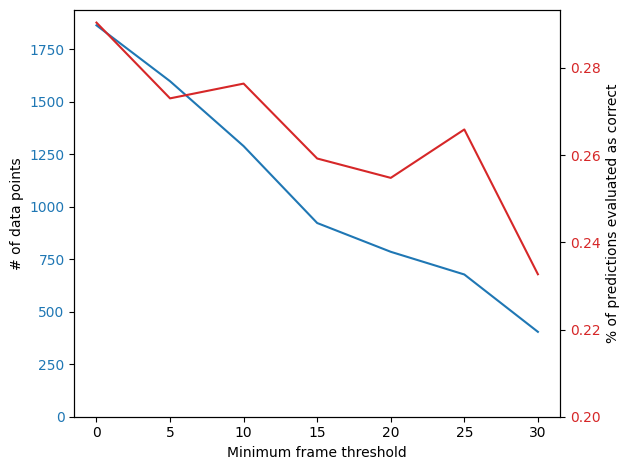

In [1016]:
_, ax1 = plt.subplots()

# Beautiful seaborn-inspired colors
primary_color = 'tab:blue'    # Deep blue - very pleasing to the eye
secondary_color = 'tab:red'  # Deep magenta/purple - great contrast

ax1.set_xlabel("Minimum frame threshold")
ax1.set_ylabel("# of data points")
ax1.plot(n_frames, data_points_size, color=primary_color)
ax1.tick_params(axis='y', labelcolor=primary_color)
ax1.set_ylim(bottom=0)

ax2 = ax1.twinx()
ax2.set_ylabel("% of predictions evaluated as correct")
ax2.plot(n_frames, acc_vals, color=secondary_color)
ax2.tick_params(axis='y', labelcolor=secondary_color)
ax2.set_ylim(bottom=.2)

plt.tight_layout()
plt.show()


Let's analyze some of the answers

In [1017]:
judge_pred_df


,pred,score,reason,video_id,n_frames
id,,,,,
2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0,incorrect,1,"The given answer states: 'Therefore, the red_s...",continuity_and_object_instance_count_183,11.0
b27163c5-d341-475b-8517-54809872081a,correct,5,The given answer 'Based on the provided scene ...,continuity_and_object_instance_count_183,11.0
9bce3140-e8e8-49dd-8574-5e961326fb16,incorrect,3,The given answer states 'There are a total of ...,continuity_and_object_instance_count_183,11.0
b8df9fbe-07db-46ab-ba17-3713c1632dbd,incorrect,1,The given answer states: 'The golden hollow sp...,continuity_and_object_instance_count_183,11.0
01c30c62-f489-4246-af18-b7b538b4cb9d,incorrect,2,The given answer states 'There are a total of ...,continuity_and_object_instance_count_183,11.0
...,...,...,...,...,...
4073994c-e4ca-4592-b001-fe0a79ab0e3f,incorrect,1,"The given answer states, 'The video does not s...",unusual_and_physically_anomalous_activities_120,8.0
3a158fb7-38cb-49b4-91e8-0cb63d6bf218,incorrect,2,The given answer provides a detailed descripti...,unusual_and_physically_anomalous_activities_120,8.0
247a493d-0d24-4f1b-bbf6-b03e8973b544,incorrect,1,The given answer states: 'The woman is using a...,unusual_and_physically_anomalous_activities_120,8.0


In [1018]:
judged_correct_mask = (judge_pred_df['pred'] == 'correct')
idx = "8360cc82-51c9-4b1e-a8b5-bb5d07e6c5c6"


print(f"Index: {idx}")
print(f"Question: {cvrr_dataset_df.loc[idx]['question']}")
print(f"\nGround truth answer:\n{cvrr_dataset_df.loc[idx]['answer']}")
print(f"\nLLM prediction:\n{ans_df.loc[idx]['text']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: 8360cc82-51c9-4b1e-a8b5-bb5d07e6c5c6
Question: Does the cleaner take a break to drink water during the task?

Ground truth answer:
No, there is no depiction of the cleaner taking a break or drinking water.

LLM prediction:
Based on the provided scene graph representation, the question "Does the cleaner take a break to drink water during the task?" cannot be definitively answered.

Here’s why:

*   **Lack of Temporal Information:** The scene graph only provides information for two frames (Frame 0 and Frame 1). It doesn't include any temporal data indicating a break or the action of drinking water.
*   **No Action of Drinking:** There are no objects, attributes, or relationships that describe someone drinking water. The scene graph focuses on the location of objects and their relationships, but doesn’t capture any actions like taking a break or consuming liquids.
*   **Focus on Location:** The scene graph primarily describes the location and arrangement of objects – a young man ne

### Distribution of confidence score

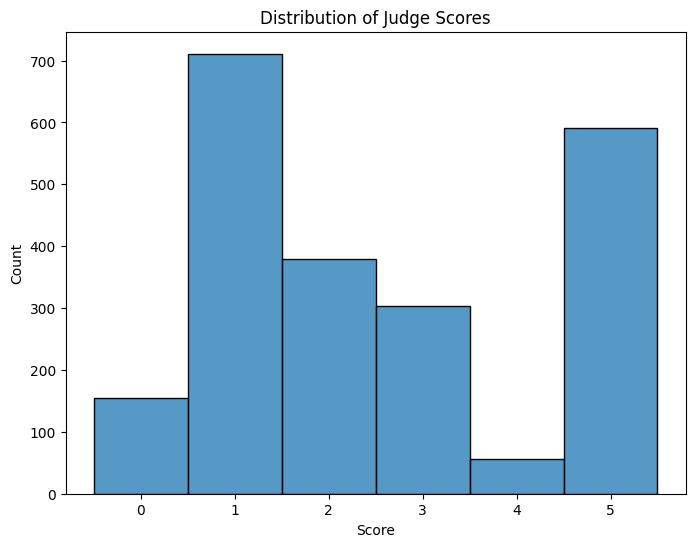

In [1019]:
# Let's see the score distribution for all the predictions

plt.figure(figsize=(8, 6))
sns.histplot(data=judge_pred_df['score'], discrete=True)
plt.title('Distribution of Judge Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()
